# 0.0 IMPORTS

In [2]:
import math
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from scipy                 import stats as ss
from datetime              import timedelta
from IPython.display       import Image
from matplotlib.pyplot     import GridSpec
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1 Helper Functions

In [64]:
#cramer's V calculation function
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

#------------------------------------------------------------------

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    

In [65]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Thiago\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. (Passo 01) DATA DESCRIPTION

## 0.1 Looking at the columns names

In [6]:
#Fazendo uma cópia do dataset para a próxima seção,
#para que nao seja necessario rodar todo o script novamente, no caso de sobre-escrever a variável por exemplo.

df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]) )
print('Number of Columns: {}'.format(df1.shape[1]) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [10]:
df1.dtypes

#Precisamos alterar a coluna 'date' para formato de DATA (dia/mes/ano)

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

#Coluna alterada. Agora aparece no dtypes como 'datetime64'

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA (Missing Values). 
How to handle them?

* Drop NA Columns (not recommended)
* Input missing values with mean or median. (when you don't have business information)
* Understand the business: Why there are missing values? (Knowing the rules of why there is missing values in the dataset, you may retrieve them).

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
#COLUMNS WITH MISSING VALUES

#competition_distance            
#competition_open_since_month    
#competition_open_since_year     
#promo2_since_week               
#promo2_since_year               
#promo_interval                  

In [14]:
#What's the maximum value in this column?
df1['competition_distance'].max()

75860.0

In [15]:
#'competition_distance'
# - Assumption: If there's no value, it might mean that this store doesn't have any near competitor 
# or the nearest one is too far to be a potential competitor.

# *We are telling to PYTHON to apply a 200.000m value if the field is NaN, 'cuz there's no competition to such sotre:*
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month (since when the nearest competitor is open?)
# - Assumption: If there's value in 'competition_distance', 
# we should have the information of since when we have this competitor)

# *So we are going to retrive this information from column 'date', but extracting year data only:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if
                                                math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)
# competition_open_since_year
# *Doing it again but to retrieve YEAR informatin now:*
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if
                                                math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

# promo2_since_week
# Let's repeat the operation with this one too, since we need to give some information to the algorithm further:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if
                                                math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if
                                                math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

# promo_interval -  describes the consecutive intervals Promo2 is started, 
# naming the months the promotion is started anew. 
# E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

#Criando um dicionário para substituir os números pelos nomes do meses:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

#Criando a nova coluna
df1['month_map'] = df1['date'].dt.month.map(month_map)

#Criando uma nova coluna, a partir de uma condição, para dizer se a loja erstá ou não participando da promoção:

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
379740,367,4,2014-07-31,7022,612,1,1,0,1,d,c,2640.0,9.0,2012.0,0,31.0,2014.0,0,Jul,0
39676,652,5,2015-06-26,5844,646,1,0,0,0,a,a,20390.0,6.0,2015.0,0,26.0,2015.0,0,Jun,0
719581,77,2,2013-09-24,7115,638,1,1,0,0,d,c,1090.0,8.0,2009.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",Sep,0
297405,307,1,2014-10-27,1935,259,1,0,0,0,a,a,18660.0,9.0,2002.0,0,44.0,2014.0,0,Oct,0
3479,135,2,2015-07-28,7764,571,1,1,0,1,d,a,5190.0,7.0,2015.0,1,1.0,2013.0,"Jan,Apr,Jul,Oct",Jul,1


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Check DTypes

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
#Changing dtypes - Some columns need to be filled with 'int' dtype instead 'float64':

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [21]:
#Numerical variables only
num_attributes = df1.select_dtypes(include=['int64','int32', 'float64'])

#Categorical variables only
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [22]:
num_attributes.sample(3)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
916970,111,7,0,0,0,0,0,7890.0,3,2013,1,37,2009,0
433745,796,7,0,0,0,0,0,7180.0,11,2012,0,23,2014,0
550886,862,7,0,0,0,0,0,2840.0,3,2010,1,14,2011,0


In [23]:
cat_attributes.sample(3)

,state_holiday,store_type,assortment,promo_interval,month_map
974603,0,d,a,"Feb,May,Aug,Nov",Feb
252030,0,a,c,"Jan,Apr,Jul,Oct",Dec
511711,0,a,a,"Jan,Apr,Jul,Oct",Mar


## 1.7.1 Numerical Atrtributes

In [24]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispertion - standart deviation(std), min, max, range, skew (data asymmetry), kurtosis (high/low-tendency of the data, outliers identifier)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Thiago\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

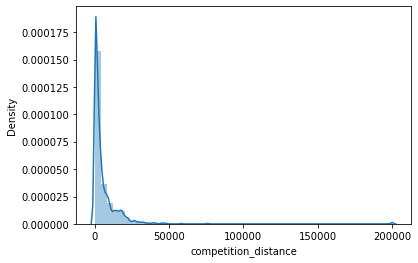

In [25]:
#Visualizing the distribuition of a given column

sns.distplot(df1['competition_distance'])

## 1.7.2 Categorical Atrtributes

In [26]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

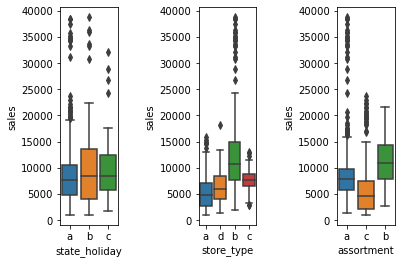

In [27]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 5, 1)
sns.boxplot(x= 'state_holiday', y= 'sales', data=aux1)

plt.subplot(1, 5, 3)
sns.boxplot(x= 'store_type', y= 'sales', data=aux1)

plt.subplot(1, 5, 5)
sns.boxplot(x= 'assortment', y= 'sales', data=aux1)

# 2.0 (Passo 02) FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

## 2.1 Criaçao das Hipoteses

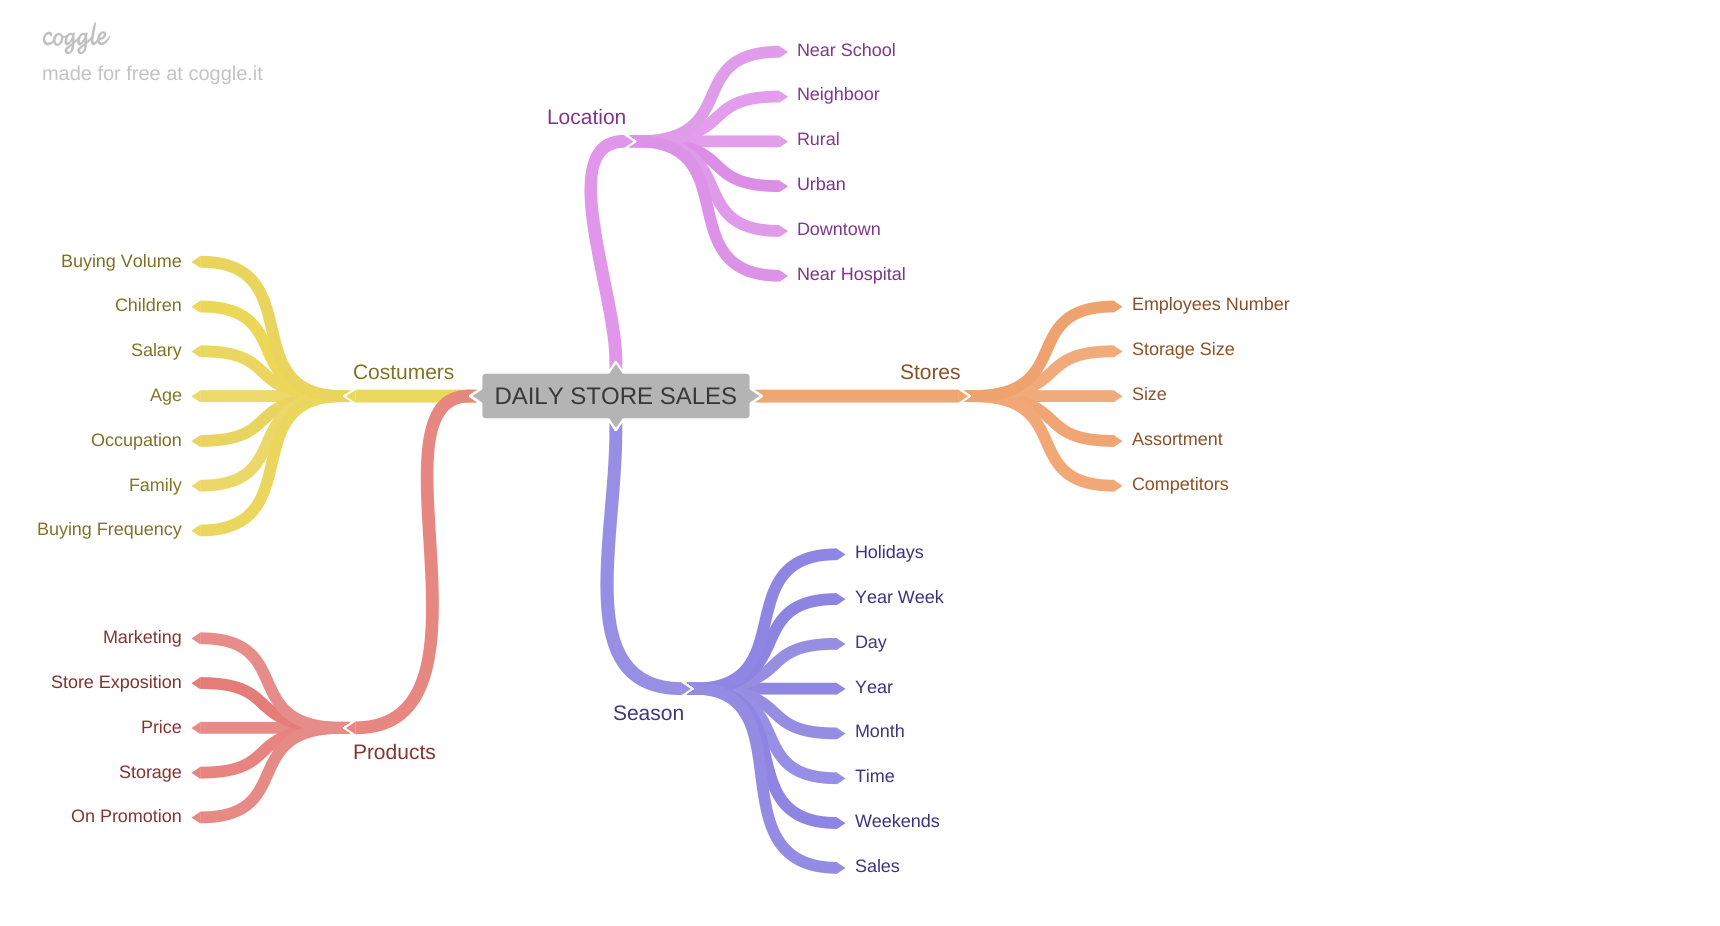

In [29]:
#MAPA MENTAL DE HIPÓTESES

Image('img/mind_map_hypothesis.png')

### 2.1.1 Hipotese Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas maiores deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.


### 2.1.2 Hipotese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas com mais dias de promoção deveriam vender mais.

### 2.1.3 Hipotese Temporal (Sazonalidade)

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriado escolares.

## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas abertas durante o feriado de natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriado escolares.


## 2.3 Feature Engineering

Variáveis a serem derivadas da variável original:

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since 
#(juntar as infos das colunas 'competition_open_since_year' e 'competition_open_since_month' numa única coluna)
df2['competition_since'] = df2.apply (lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
                                     
#assortment (sobrescrevendo a mesma variável aplicando as classificaçãoes 'basic', 'extra' e 'extended')
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended')

#state_holiday 
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x =='b' else 'christimas' if x=='c' else 'regular_day')

<ipython-input-30-de7267b2cfb8>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 (Passo 03) VARIABLE FILTERING

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [34]:
#excluindo linhas onde a coluna 'sales' é igual a ZERO e onde a coluna 'open' é igual a ZERO (indicando que loja estava fechada)
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1 Seleção das Colunas

In [35]:
#Excluindo colunas que não serão relevantes
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 (Passo 04) EXPLORATORY DATA ANALYSIS

In [37]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

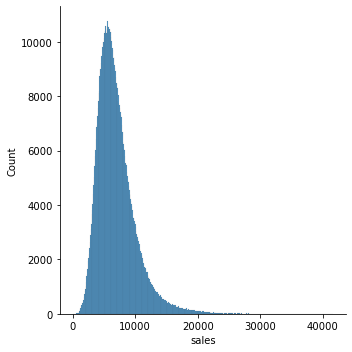

In [38]:
sns.displot (df4['sales']);

### 4.1.2 Numerical Variable

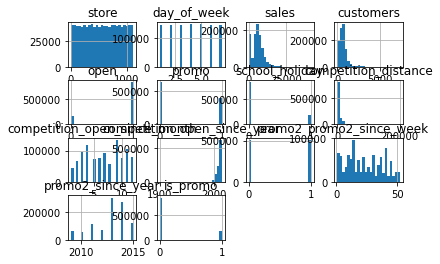

In [39]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [40]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126        christimas
Name: state_holiday, dtype: object

In [42]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [43]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

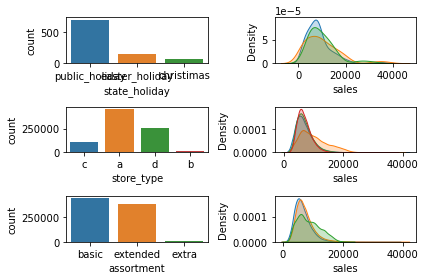

In [44]:
#state_holiday
plt.subplot (3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day'] #filtro
sns.countplot (x='state_holiday', data=a)

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label='christimas', shade=True)

#store_type
plt.subplot (3, 2, 3)
sns.countplot (x='store_type', data=df4)

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot (3, 2, 5)
sns.countplot (x='assortment', data=df4)

plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.tight_layout();


## 4.2 Analise Bivariada
Analisar o impacto de uma variável em uma variável resposta/Validação das hipóteses.

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** - Lojas com o MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

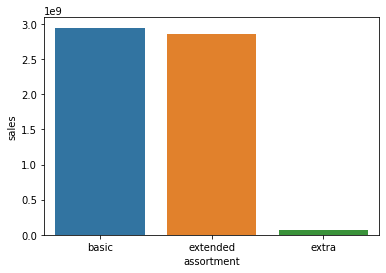

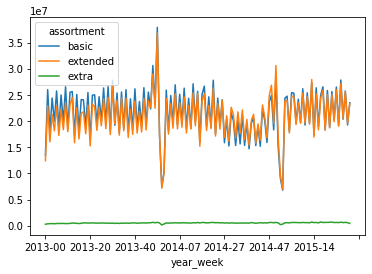

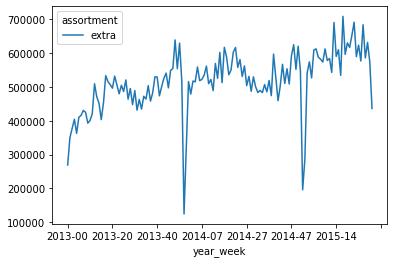

In [45]:
#verificando a primeira etapa da hipótese
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot (x='assortment', y='sales', data=aux1);

#aprofundando a análise para verificar se o comportamento das vendas se manteve ao longo do tempo
aux2 = df4[[ 'year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

#filtrando o outlier separadamente
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

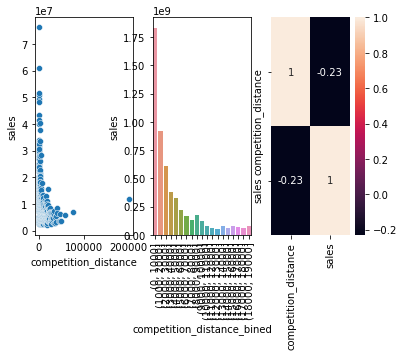

In [46]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1, 3, 1)
sns.scatterplot (x='competition_distance', y='sales', data=aux1);

plt.subplot (1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_bined'] = pd.cut (aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot (x='competition_distance_bined', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [47]:
aux1.sample(4)

,competition_distance,sales,competition_distance_bined
108,1180.0,22835249,"(1000.0, 2000.0]"
638,32240.0,4802197,NaN
197,2270.0,8782287,"(2000.0, 3000.0]"
447,8400.0,5737615,"(8000.0, 9000.0]"


### H3. Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** - Lojas com competidores a MAIS TEMPO vendem MENOS.

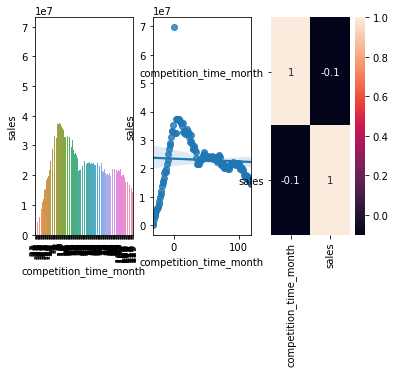

In [48]:
plt.subplot (1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot (1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method="pearson"), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por mais tempo VENDEM MENOS, depois de um certo período de promoção.


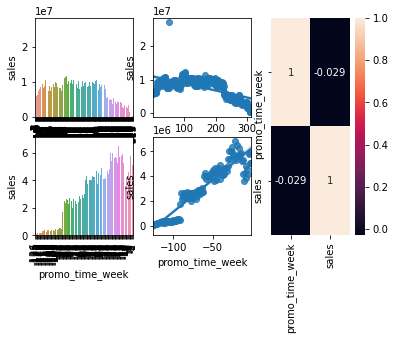

In [49]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec (2, 3)

plt.subplot (grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot (grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot (grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot (grid [1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot (grid [:, 2])
sns.heatmap (aux1.corr(method="pearson"), annot=True);


### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>



### H6. Lojas com mais promoções consecutivas (extendidas) deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas VENDEM MENOS.

In [50]:
#verificando a soma das vendas de acordo com a atual promoção das lojas (tradicional ou extendida):

df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


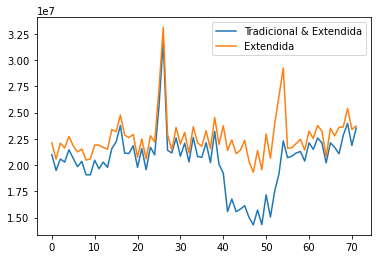

In [51]:
#VERIFICANDO O COMPORTAMENTO AO LONGO DO TEMPO:
#Será que lojas que tiveram promoção apenas no período tradicional mudaram de comportamento ao entrar no período de promoção extendida?

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de natal VENDEM MENOS.

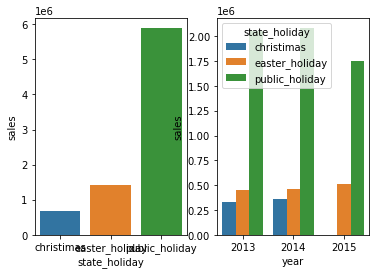

In [52]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot (1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem MENOS ao longo dos anos.

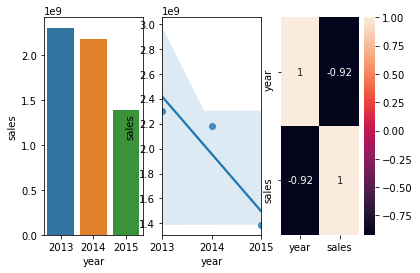

In [53]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot (1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - Lojas vendem MENOS no segundo semestre do ano.

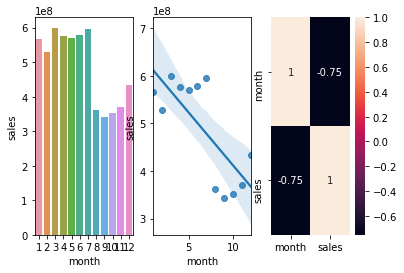

In [54]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot (1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - Lojas VENDEM MAIS depois do dia 10 de cada mês.

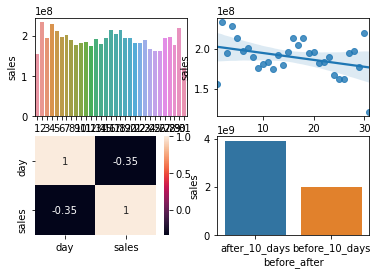

In [55]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot (2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot (2, 2, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True)

plt.subplot (2, 2, 4)
aux1['before_after'] = aux1['day'].apply (lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot (x='before_after', y='sales', data=aux2);


### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** -Lojas VENDEM MENOS nos finais de semana.

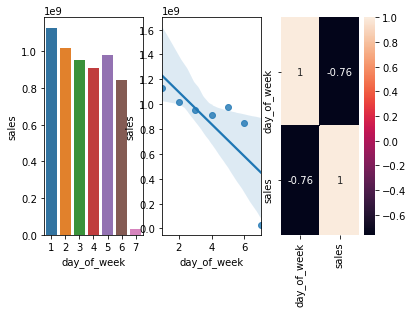

In [56]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot (1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriado escolares.
**VERDADEIRA** - Lojas VENDEM MENOS durante os feriados escolares (exceto os meses de Julho e Agosto).

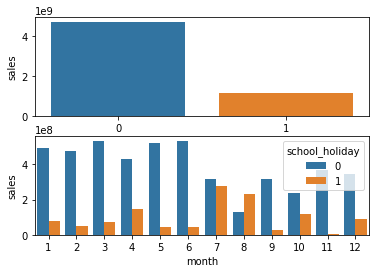

In [57]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot (2, 1, 1)
sns.barplot (x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot (2, 1, 2)
sns.barplot (x='month', y='sales', hue='school_holiday', data=aux2);

## 4.2.1 Resumo das Hipóteses

In [58]:
from tabulate import tabulate

In [59]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H7          Falsa        Baixa
H8          Falsa        Media
H9          Falsa        Alta
H10         Falsa        Alta
H11         Verdadeira   Alta
H12         Verdadeira   Alta
H13         Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

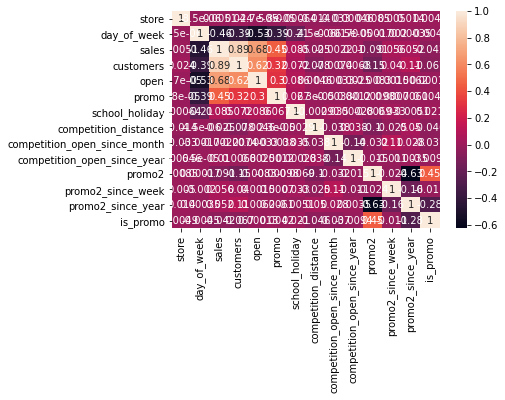

In [60]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

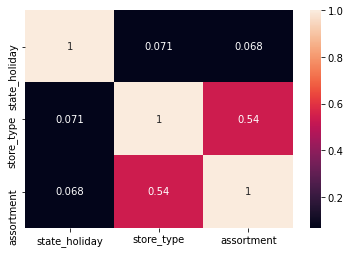

In [63]:
#categorical data only
a = df4.select_dtypes(include = 'object')

#calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#final dataset
d = pd.DataFrame ({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 (Passo 05) DATA PREPARATION

In [66]:
df5 = df4.copy()

## 5.1. Normalization

- Due to the inexistance of normal variables in this dataset, we're not going to do any normalization.

## 5.2. Rescaling

- Let's select the variables to rescale:

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform (df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform (df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform (df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform (df5[['year']].values)

#OBS.: IF THERE'S OUTLIERS WE'RE GOINT TO USE RobustScaler, SO IT'S IMPORTANT TO CHECK ON BY ONE.

## 5.3. Transformation

### 5.3.1. Encoding

In [69]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform (df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [70]:
# month
# day
# week_of_year
# day_of_week